# Gaussian Mixture Model

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs #to generate data
from sklearn.mixture import GaussianMixture
import numpy as np
sns.set_context("notebook", font_scale=1.5)

In [2]:
#create simulated dataset with 4 different clusters
X, y = make_blobs(n_samples=500, #number of observations
                  centers=4, #number of classes or populations
                  cluster_std=2, #how is the spread of these classes or populations around the mean
                  random_state=2021)

In [3]:
#check up the shape of the X matrix and how many levels y has
f'the shape of X is {X.shape} while y has the values:{np.unique(y)}'

'the shape of X is (500, 2) while y has the values:[0 1 2 3]'

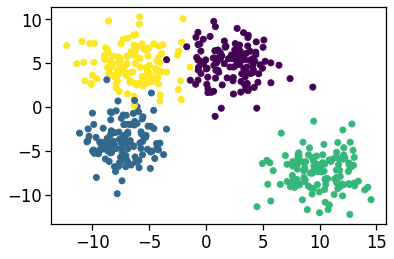

In [4]:
#plot X according to y
plt.scatter(X[:,0], X[:,1], c=y);  #we have 4 clusters of datapoints

In [5]:
#we make a dataframe out of X and y
data=pd.DataFrame(X, columns=['Feature1','Feature2'])
data['classes']=y
data.head(5)

,Feature1,Feature2,classes
0,-0.685085,4.217225,0
1,11.455507,-5.728207,2
2,2.230017,5.938229,0
3,3.705751,1.875764,0
4,-3.478871,-2.518452,1


In [6]:
#build Gaussian Mixture model with 3 clusters
gmm = GaussianMixture(4,#number of classes of clusters 
                     covariance_type='full', 
                     random_state=0).fit(data[['Feature1','Feature2']])

In [7]:
#let us make preditions
predicted = gmm.predict(data[['Feature1','Feature2']])
data["predicted_class"]=predicted

In [8]:
data.head(5)

,Feature1,Feature2,classes,predicted_class
0,-0.685085,4.217225,0,2
1,11.455507,-5.728207,2,1
2,2.230017,5.938229,0,2
3,3.705751,1.875764,0,2
4,-3.478871,-2.518452,1,3


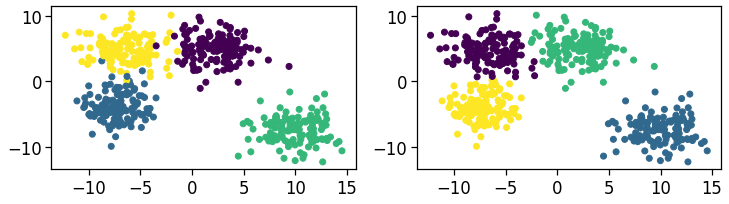

In [9]:
plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
plt.scatter(data['Feature1'], data['Feature2'], c=data['classes'])
plt.subplot(1, 2, 2)
plt.scatter(data['Feature1'], data['Feature2'], c=data['predicted_class'])

In [10]:
#visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output
#this function is from internet --https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html--
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

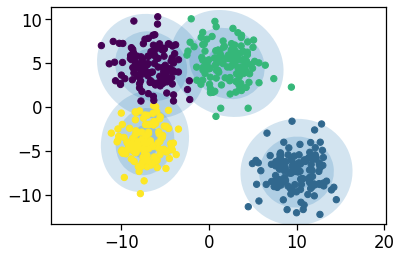

In [11]:
plot_gmm(gmm, X)

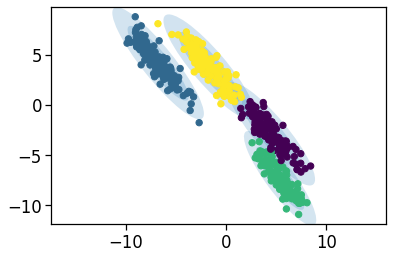

In [12]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))#four in total
plot_gmm(gmm, X_stretched)

In [15]:
#check the score
gmm.score(X)

-30.24644691547929

**Identify the right number of clusters of the data**
**OR How many components?**

In [16]:
#what if we did not know how many clusters we have
#we have to set up a range of assumed number for clusters
n_components = np.arange(1, 21)
#using list comprehension
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

#using for loop
#models=[]
#for i in np.arange(1, 21):
    #gmm=GaussianMixture(i,covariance_type='full', random_state=0).fit(X)
    #models.append(gmm)   

In [17]:
#compute AIC/BIC scores with scikit-learn to compare the generated models to find the best
AIC=[i.aic(X) for i in models]
BIC=[i.bic(X) for i in models]

In [18]:
#make a dataframe out of it
information=pd.DataFrame({'components':np.arange(1, 21),
                         'AIC':AIC,
                         'BIC':BIC})

In [19]:
#check this dataframe
information.head(4)

,components,AIC,BIC
0,1,6502.545110,6523.618150
1,2,5995.947707,6042.308396
2,3,5712.252796,5783.901134
3,4,5605.503135,5702.439121


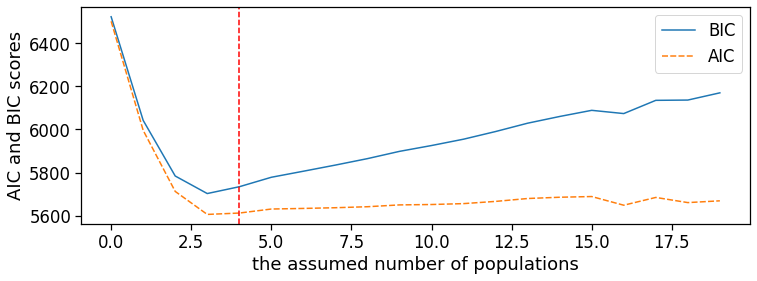

In [20]:
plt.figure(figsize=(12,4))
sns.lineplot(data=information[["BIC","AIC"]])
plt.axvline(x=4, color='r', linestyle='--')
plt.xlabel("the assumed number of populations")
plt.ylabel("AIC and BIC scores")
plt.show() 

**GMM as Density Estimation**

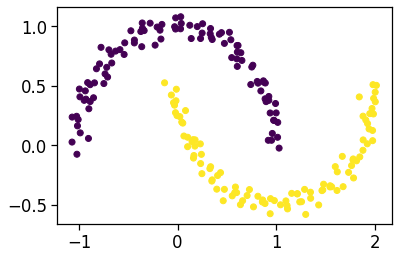

In [21]:
#describing the distribution of the data
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], c=ymoon); #data of two populations but there is some overlapping

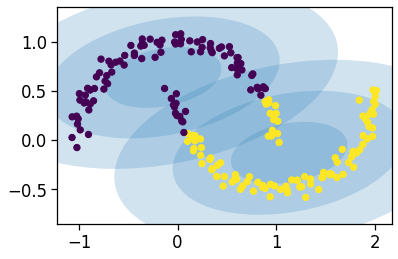

In [22]:
#apply GMM to see if this model works with this kind of distribution
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon) #a clear sign of overlapping --> subdivide this population

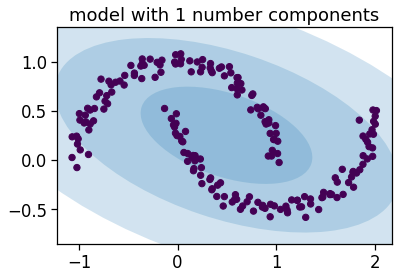

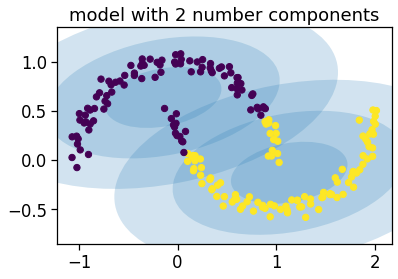

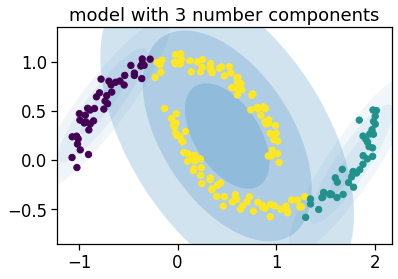

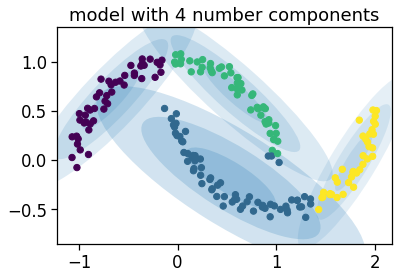

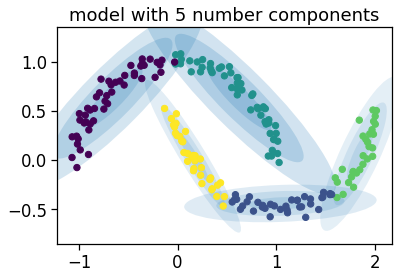

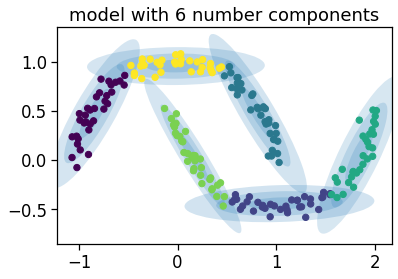

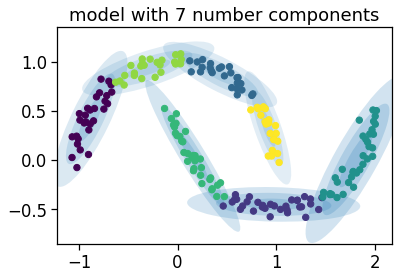

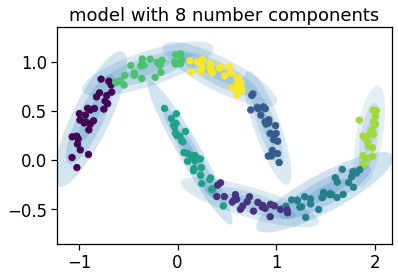

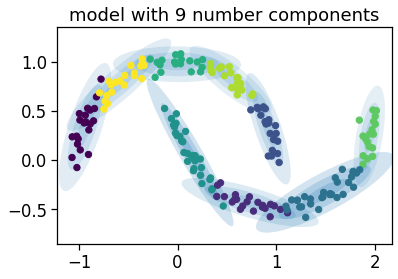

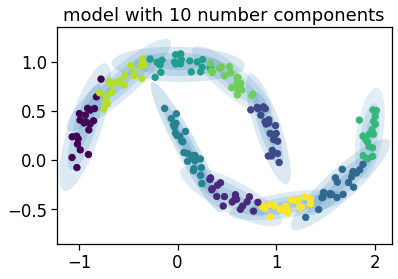

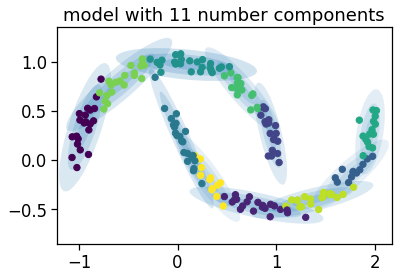

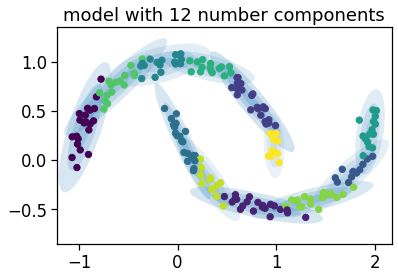

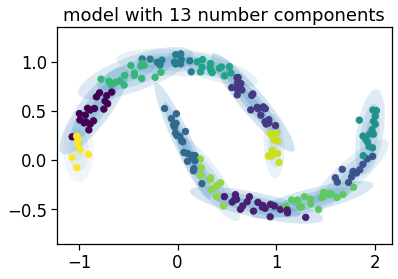

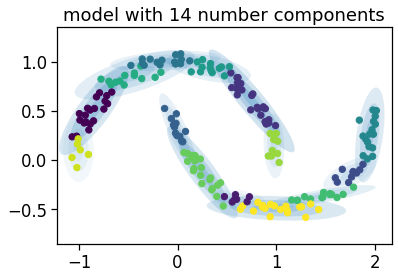

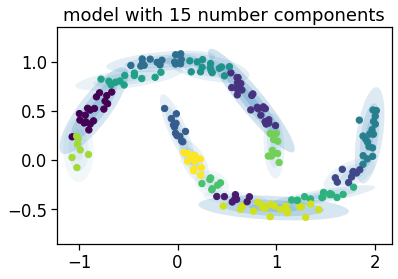

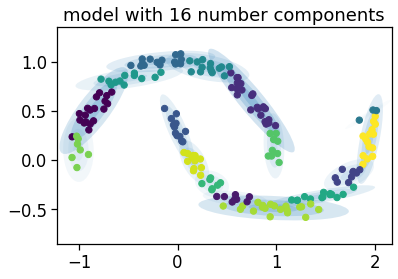

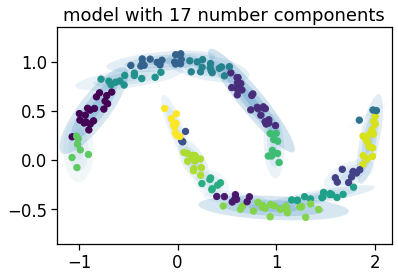

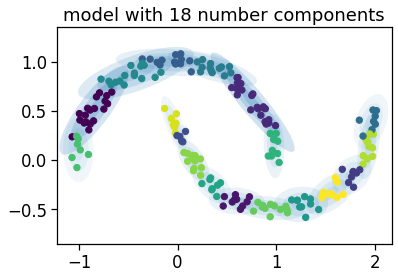

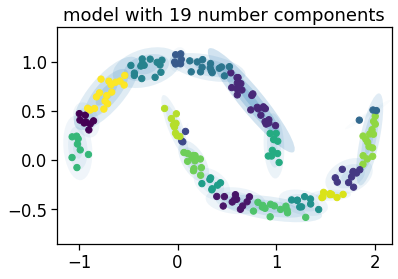

In [23]:
#make a for loop to plot all possible number of components
for i in range(1,20):
    mod=GaussianMixture(n_components=i, covariance_type='full', random_state=0)
    plot_gmm(mod, Xmoon)
    plt.title(f'model with {i} number components')
    plt.show() #the best was 10

In [24]:
# train an ECOD detector
#from pyod.models.ecod import ECOD
#clf = ECOD()
#clf.fit(X_train)

# get outlier scores
#y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
#y_test_scores = clf.decision_function(X_test)  # predict raw outlier scores on test

# K-means clustering

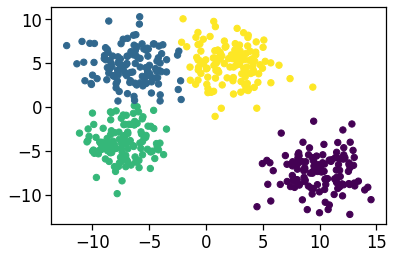

In [25]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist #Compute distance between each pair of the two collections of inputs.

kmeans = KMeans(4, random_state=0)
clusters = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=40, cmap='viridis');

In [26]:
#this function is from internet --https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html--
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    clusters = kmeans.fit_predict(X)#predict how many clusters using the trained model
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=clusters, s=40, cmap='viridis', zorder=2)#plotting the datapoinsts
    # using zorder You can change the order for individual artists background or to front
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_ #the centroids
    radii = [cdist(X[clusters == i], [center]).max() for i, center in enumerate(centers)] #the distance
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))#plotting circle around clusters

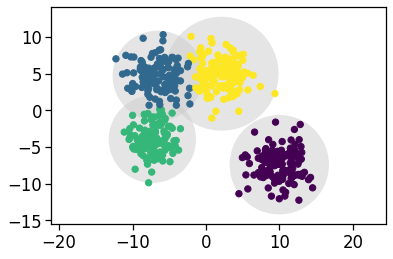

In [27]:
plot_kmeans(kmeans,X,4,0) #I see a clear overlapping which is BAD!!!!!!!!!!!

# PCA analysis

In [28]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [29]:
sns.get_dataset_names() # iris or penguins

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'taxis',
 'tips',
 'titanic']

In [101]:
#the penguin data from seaborn
penguin = sns.load_dataset('penguins')

In [102]:
penguin.head()
penguin.dropna(inplace=True)

In [121]:
#for PCA we need only numerical data so we have to select specific features
data_num=penguin.filter(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])
data_ref=penguin.filter(['species', 'island', 'sex'])

In [122]:
#make pipeline
random_state = 0
pca_scaled = make_pipeline(StandardScaler(),
                    PCA(n_components=4, random_state=random_state))

In [129]:
scaler = StandardScaler()
scaled= scaler.fit_transform(data_num)

In [130]:
#pca analysis
pca = PCA(n_components=4)

#fit PCA model to data
pca_fit = pca.fit(scaled)

In [131]:
pca_fit.explained_variance_ratio_

array([0.68633893, 0.19452929, 0.09216063, 0.02697115])

In [114]:
pc_scaled_df

,PC1,PC2,PC3,PC4,species,sex
0,-1.853593,0.032069,-0.234902,0.528397,Adelie,Male
1,-1.316254,-0.443527,-0.027470,0.401727,Adelie,Female
2,-1.376605,-0.161230,0.189689,-0.528662,Adelie,Female
3,-1.885288,-0.012351,-0.628873,-0.472893,NaN,NaN
4,-1.919981,0.817598,-0.701051,-0.196416,Adelie,Female
...,...,...,...,...,...,...
328,1.997716,-0.976771,0.379425,0.160892,Gentoo,Female
329,1.832651,-0.784510,0.240758,-0.008955,Gentoo,Male
330,2.751505,0.266556,-0.419306,0.236256,Gentoo,Female
331,1.713854,-0.725875,-0.262764,0.330004,Gentoo,Male


In [117]:
penguins_pc_scaled

array([[-1.85359302,  0.03206938, -0.23490166,  0.52839663],
       [-1.31625406, -0.44352677, -0.02747008,  0.40172663],
       [-1.37660509, -0.16123048,  0.18968926, -0.5286619 ],
       ...,
       [ 2.75150503,  0.26655572, -0.4193065 ,  0.23625562],
       [ 1.71385366, -0.72587516, -0.26276382,  0.33000361],
       [ 2.01853683,  0.33655372, -0.15533072,  0.43880173]])

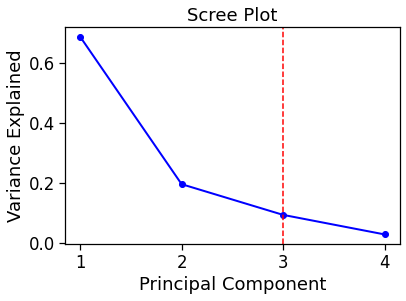

In [138]:
PC_values = np.arange(pca_fit.n_components_) + 1
plt.plot(PC_values, pca_fit.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.axvline(x=3, color='r', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

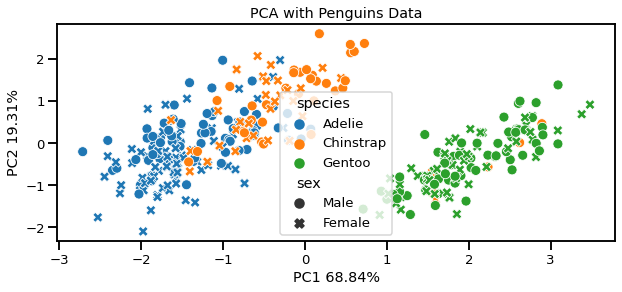

In [120]:
plt.figure(figsize=(10,4))
with sns.plotting_context("talk",font_scale=0.8):
    sns.scatterplot(x="PC1", y="PC2",
                    data=pc_scaled_df, 
                    hue="species",
                    style="sex",
                    s=100)
    plt.xlabel('PC1 68.84%')
    plt.ylabel('PC2 19.31%')
    plt.title("PCA with Penguins Data")

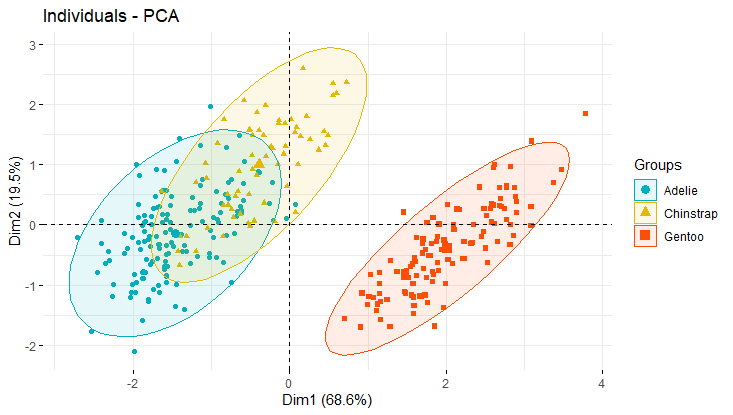

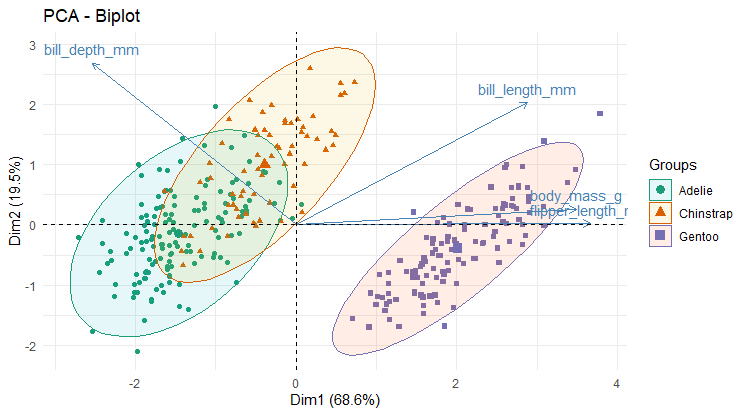

<AxesSubplot:xlabel='species', ylabel='bill_depth_mm'>

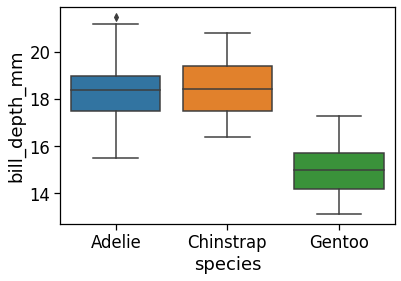

In [239]:
import seaborn as sns
sns.boxplot(x="species", y="bill_depth_mm", data=penguin)

# NMF 


In [2]:
#import libraries
import numpy as np
from sklearn.decomposition import NMF
import pandas as pd
from sklearn.impute import KNNImputer

In [70]:
#import the data
ratings = pd.read_csv('ratings.csv')
ratings=ratings.drop('timestamp', axis=1) #drop the timestamp column

In [51]:
ratings.sample(5)# the data should be reshaped

,userId,movieId,rating
23357237,151656,200820,2.5
8351258,54395,27660,4.0
5121923,33294,4788,3.5
17786032,115274,3753,4.5
21580727,140324,7234,4.0


In [71]:
ratings.isna().sum() #sounds like I do not have any missing data..

userId     0
movieId    0
rating     0
dtype: int64

In [72]:
#fill the missing data using n_neighbors method
#imputer = KNNImputer(n_neighbors=2)#check this......
#ratings_imp = pd.DataFrame(imputer.fit_transform(ratings), 
                       #index = ratings.index, 
                       #columns = ratings.columns)

In [81]:
ratings.head(5)

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [78]:
#how many unique id numbers for movie???
len(ratings['movieId'].unique())

59047

In [80]:
ratings['movieId'].describe()

count    2.500010e+07
mean     2.138798e+04
std      3.919886e+04
min      1.000000e+00
25%      1.196000e+03
50%      2.947000e+03
75%      8.623000e+03
max      2.091710e+05
Name: movieId, dtype: float64

In [132]:
#I do not need the whole dataset ## make a random sampling ##
ratings_limited=ratings.query('userId > 10 and userId  < 100 and movieId > 100 and movieId < 5000')# always put the and

In [133]:
ratings_limited.shape

(7562, 3)

In [134]:
ratings_limited.head(5)

,userId,movieId,rating
1690,11,277,2.5
1691,11,372,4.5
1692,11,527,4.0
1693,11,593,4.5
1694,11,1203,2.5


In [141]:
#reshape the data and automatically fill the NaNs with zeros
pivoted = ratings_limited.pivot_table(index="userId", columns="movieId", values="rating",fill_value=0)

In [142]:
pivoted

movieId,101,103,104,105,110,111,112,118,123,125,...,4969,4971,4973,4975,4976,4979,4981,4989,4993,4995
userId,,,,,,,,,,,,,,,,,,,,,
11,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,0.0
12,4.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0.0,5.0,0.0,0.0,4.5,0,0,2.0,0.0
13,0.0,0,4,0.0,4.5,0.0,4.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,4.5,0.0
14,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0.0,5.0,0.0,0.0,0.0,0,0,4.0,0.0
15,0.0,0,0,0.0,3.0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0,0,0.0,4.5,0.0,0.0,0,0.0,0,...,0,0.0,4.0,0.0,0.0,0.0,0,0,0.0,3.0
96,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
97,0.0,0,0,0.0,3.5,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0,0,5.0,0.0


In [164]:
films = pivoted.columns.tolist()

In [166]:
#films

**make a model for multiple components to find the best using GMM model then making NMF**

In [148]:
import warnings
warnings.filterwarnings("ignore")

In [151]:
n_components = np.arange(1, 21)
#using list comprehension
models_rating = [GaussianMixture(n, covariance_type='full', random_state=0).fit(pivoted) for n in n_components]

In [152]:
#compute AIC/BIC scores with scikit-learn to compare the generated models to find the best
AIC=[i.aic(pivoted) for i in models_rating ]
BIC=[i.bic(pivoted) for i in models_rating ]

In [153]:
#make a dataframe out of it
criteria=pd.DataFrame({'components':np.arange(1, 21),
                         'AIC':AIC,
                         'BIC':BIC})

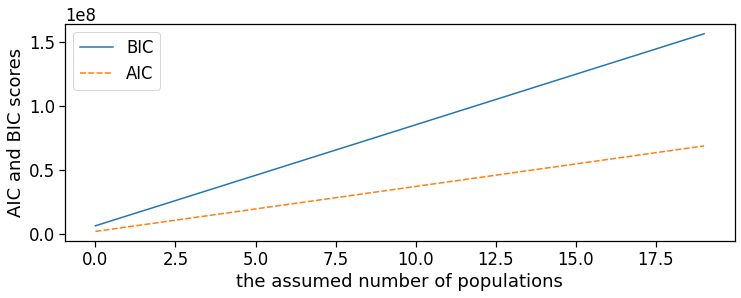

In [154]:
plt.figure(figsize=(12,4))
sns.lineplot(data=criteria[["BIC","AIC"]])
#plt.axvline(x=4, color='r', linestyle='--')
plt.xlabel("the assumed number of populations")
plt.ylabel("AIC and BIC scores")
plt.show() 

In [155]:
# now make nmf
nmf = NMF(n_components=2)
nmf.fit(pivoted)

NMF(n_components=2)

In [171]:
nmf.reconstruction_err_

264.6526421320817

In [167]:
#make Q
Q = pd.DataFrame(nmf.components_, 
                 columns=films, 
                 index=['feature1', 'feature2'])
Q

,101,103,104,105,110,111,112,118,123,125,...,4969,4971,4973,4975,4976,4979,4981,4989,4993,4995
feature1,0.103016,0.005452,0.245037,0.166728,1.445571,0.372451,0.309634,0.000000,0.06937,0.010584,...,0.064846,0.028465,1.14777,0.073708,0.075654,0.243287,0.086461,0.030831,1.391731,0.802913
feature2,0.098015,0.001259,0.067118,0.203691,0.138566,0.299208,0.000000,0.124179,0.00000,0.208085,...,0.001576,0.000000,0.00000,0.000000,0.001838,0.112339,0.002101,0.000000,0.000000,0.000000


In [168]:
# tranform to get P
P = pd.DataFrame(nmf.transform(pivoted), 
                 columns=['feature1', 'feature2'], 
                 index=pivoted.index)
P

,feature1,feature2
userId,,
11,0.216312,0.000000
12,1.736295,4.268478
13,2.943369,0.000000
14,0.562145,0.000000
15,1.109795,0.355866
...,...,...
95,1.588215,0.000000
96,0.190558,0.000000
97,0.273534,0.399475


In [170]:
recommendations_reconstructed = pd.DataFrame(np.dot(P, Q), 
                                  index=pivoted.index, 
                                  columns=films)

In [172]:
abs(pivoted - recommendations_reconstructed).head()

movieId,101,103,104,105,110,111,112,118,123,125,...,4969,4971,4973,4975,4976,4979,4981,4989,4993,4995
userId,,,,,,,,,,,,,,,,,,,,,
11,0.022283,0.001179,0.053004,0.036065,0.312694,0.080565,0.066978,0.000000,0.015006,0.002289,...,0.014027,0.006157,0.248276,0.015944,0.016365,0.052626,0.018703,0.006669,3.698952,0.173679
12,3.402761,0.014840,0.711948,1.158941,3.101404,1.923847,0.537617,0.530057,0.120447,0.906582,...,0.119318,0.049423,3.007133,0.127979,0.139205,3.598064,0.159091,0.053532,0.416455,1.394094
13,0.303213,0.016047,3.278764,0.490742,0.245150,1.096260,3.088632,0.000000,0.204182,0.031152,...,0.190866,0.083782,3.378310,0.216950,0.222677,0.716084,0.254488,0.090747,0.403623,2.363269
14,0.057910,0.003065,0.137747,0.093725,0.812621,0.209371,0.174060,0.000000,0.038996,0.005950,...,0.036453,0.016001,4.354787,0.041435,0.042528,0.136763,0.048604,0.017332,3.217645,0.451354
15,0.149206,0.006499,0.295826,0.257521,1.346401,0.519822,0.343631,0.044191,0.076987,0.085796,...,0.072527,0.031590,1.273790,0.081801,0.084614,0.309977,0.096702,0.034216,1.544536,0.891069


**Add a new film you have to repeat the analysis, but adding new customer just use the model to fit and transfrom**